In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from regressor import Flip7Model
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from flip7_game import Flip7Game
from train_regressor import create_dataset, train, evaluate

In [10]:
# Pick a comfortable color palette
colors = sns.color_palette("muted", 3)
ds: TensorDataset = create_dataset(5000)
ds_test: TensorDataset = create_dataset(1000)

Generating dataset: 100%|██████████| 1000/1000 [00:11<00:00, 90.89it/s]


In [11]:
# Example model definition
model = Flip7Model()
train(model, ds, ds_test, 30, 128, 0.01)

# Collect predictions
data_loader = DataLoader(ds_test, shuffle=False, batch_size=32)
predictions = []
with torch.no_grad():
    for batch in data_loader:
        in_data, _ = batch
        prediction = model(in_data)
        predictions.append(prediction)
predictions = torch.cat(predictions, dim=0).squeeze().numpy()

Epoch   1 | Train Loss: 2.171253
Epoch   2 | Train Loss: 1.446280
Epoch   3 | Train Loss: 1.262079
Epoch   4 | Train Loss: 1.176226
Epoch   5 | Train Loss: 1.101992 | Test Loss: 0.717517
Epoch   6 | Train Loss: 1.056032
Epoch   7 | Train Loss: 1.101493
Epoch   8 | Train Loss: 1.087344
Epoch   9 | Train Loss: 0.963482
Epoch  10 | Train Loss: 1.033259 | Test Loss: 0.642939
Epoch  11 | Train Loss: 0.950218
Epoch  12 | Train Loss: 0.988793
Epoch  13 | Train Loss: 1.047025
Epoch  14 | Train Loss: 1.059028
Epoch  15 | Train Loss: 0.920857 | Test Loss: 0.654039
Epoch  16 | Train Loss: 0.946982
Epoch  17 | Train Loss: 1.086559
Epoch  18 | Train Loss: 0.867980
Epoch  19 | Train Loss: 1.123695
Epoch  20 | Train Loss: 0.895481 | Test Loss: 0.608369
Epoch  21 | Train Loss: 0.929738
Epoch  22 | Train Loss: 0.987761
Epoch  23 | Train Loss: 0.966788
Epoch  24 | Train Loss: 0.941959
Epoch  25 | Train Loss: 0.965769 | Test Loss: 0.682919
Epoch  26 | Train Loss: 1.020756
Epoch  27 | Train Loss: 0.921742

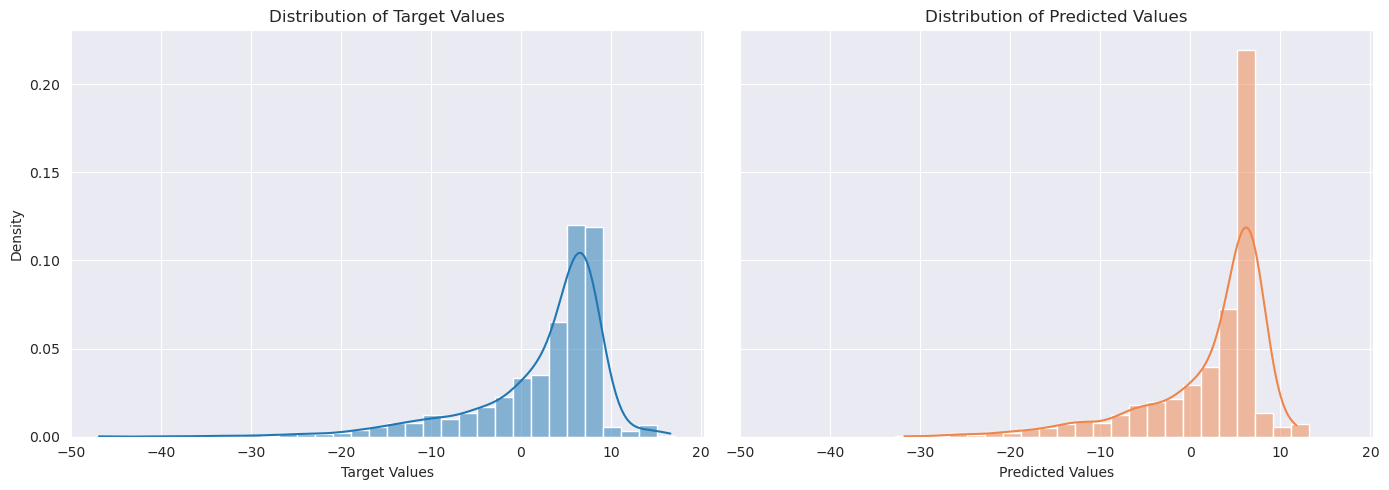

In [12]:
# Convert to 1D numpy array
targets = ds_test.tensors[1].numpy()

# Determine global x-axis range
x_min = min(targets.min(), predictions.min())
x_max = max(targets.max(), predictions.max())

# Define consistent bins
bin_width = 2.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Plot target values
sns.histplot(targets, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0], legend=False)
axes[0].set_title('Distribution of Target Values')
axes[0].set_xlabel('Target Values')
axes[0].set_ylabel('Density')

# Plot predictions
sns.histplot(predictions, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1], legend=False)
axes[1].set_title('Distribution of Predicted Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [18]:
def baseline_policy(game: Flip7Game):
    expected_value = game.mc_sample_expected_score_difference_of_in(200)
    return True if expected_value > 0 else False

def learned_policy(game: Flip7Game):
    obs = np.array([game.card_counts_in_hand[c] for c in Flip7Game.CARD_TYPES], dtype=np.float32)
    observation = torch.tensor(obs).unsqueeze(0)
    expected_value = model(observation).item()
    return True if expected_value > 0 else False

def luca_bot(_: Flip7Game):
    return True

def luca_bot2(game: Flip7Game):
    if game.score > 30 and not game.has_second_chance:
        return False
    return True

In [19]:
round_rewards_baseline = evaluate(baseline_policy)
round_rewards_model = evaluate(learned_policy)
round_rewards_luca = evaluate(luca_bot)
round_rewards_luca2 = evaluate(luca_bot2)

100%|██████████| 1000/1000 [00:11<00:00, 89.00it/s]


Evaluation complete: 
	Avg score per move: 4.84
	Avg score per round: 20.08


100%|██████████| 1000/1000 [00:00<00:00, 8506.28it/s]


Evaluation complete: 
	Avg score per move: 4.75
	Avg score per round: 20.63


100%|██████████| 1000/1000 [00:00<00:00, 234856.60it/s]


Evaluation complete: 
	Avg score per move: 2.25
	Avg score per round: 11.09


100%|██████████| 1000/1000 [00:00<00:00, 214740.12it/s]

Evaluation complete: 
	Avg score per move: 4.00
	Avg score per round: 18.92


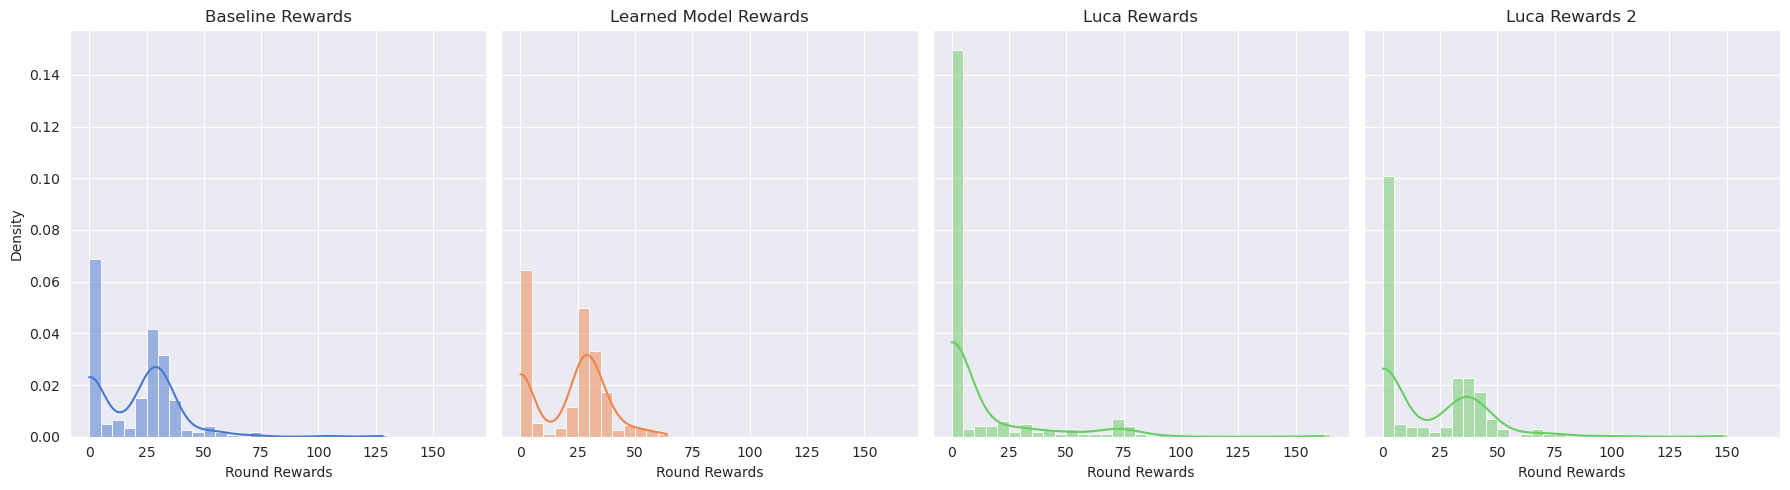

In [22]:
# Convert rewards to numpy arrays
round_rewards_baseline = np.array(round_rewards_baseline)
round_rewards_model = np.array(round_rewards_model)
round_rewards_luca = np.array(round_rewards_luca)
round_rewards_luca2 = np.array(round_rewards_luca2)

# Determine global x-axis range
x_min = min(round_rewards_baseline.min(), round_rewards_model.min(), round_rewards_luca.min())
x_max = max(round_rewards_baseline.max(), round_rewards_model.max(), round_rewards_luca.max())

# Define consistent bins
bin_width = 5.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)

# Plot Baseline
sns.histplot(round_rewards_baseline, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0])
axes[0].set_title('Baseline Rewards')
axes[0].set_xlabel('Round Rewards')
axes[0].set_ylabel('Density')

# Plot Learned Model
sns.histplot(round_rewards_model, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1])
axes[1].set_title('Learned Model Rewards')
axes[1].set_xlabel('Round Rewards')
axes[1].set_ylabel('Density')

# Plot Luca
sns.histplot(round_rewards_luca, bins=bins, kde=True, stat='density', color=colors[2], ax=axes[2])
axes[2].set_title('Luca Rewards')
axes[2].set_xlabel('Round Rewards')
axes[2].set_ylabel('Density')

# Plot Luca 2
sns.histplot(round_rewards_luca2, bins=bins, kde=True, stat='density', color=colors[2], ax=axes[3])
axes[3].set_title('Luca Rewards 2')
axes[3].set_xlabel('Round Rewards')
axes[3].set_ylabel('Density')

# Align y-axis limits
max_y = max(
    axes[0].get_ylim()[1],
    axes[1].get_ylim()[1],
    axes[2].get_ylim()[1]
)
for ax in axes:
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()

In [16]:
torch.save(model.state_dict(), "model")